In [1]:
import torch
import numpy as np
import torchvision
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter
from torch.optim.sgd import SGD
from torchvision import models
from torchsummary import summary
import torch.nn as nn
import torch.nn.functional as F
from torchmetrics import F1Score, Accuracy
import time

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Assignment 2 in ML. Task 2
### Ostapovich Oleg
#### Section 1: Data Reading

In [3]:
epochs = 20
learning_rate = 0.001

In [4]:
# Custom MinMaxScaler
class MinMaxScaler():
    def __call__(self, tensor: torch.Tensor) -> torch.Tensor:
        dist = (tensor.max(dim=1, keepdim=True)[0] - tensor.min(dim=1, keepdim=True)[0])
        dist[dist==0.] = 1.
        scale = 1.0 /  dist
        tensor.mul_(scale).sub_(tensor.min(dim=1, keepdim=True)[0])
        return tensor

In [5]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Resize([32,32]),
     # MinMaxScaler()
     ])

dataset = torchvision.datasets.GTSRB(root='./data', download=True, transform=transform)

In [6]:
# This code shows that data was scaled
dataset.__getitem__(0)[0].min()

tensor(0.2100)

#### Section 2: Exploration and preprocessing

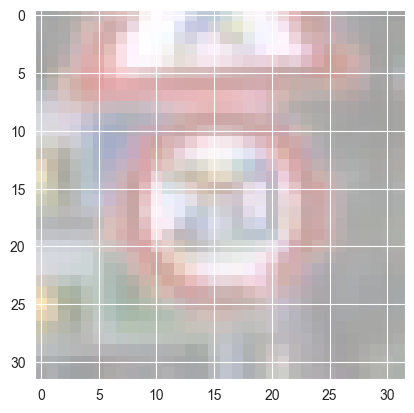

In [7]:
import matplotlib.pyplot as plt
img = dataset.__getitem__(0).__getitem__(0)
img = img / 2 + 0.5
npimg = img.numpy()
plt.imshow(np.transpose(npimg, (1, 2, 0)))
plt.show()

In [8]:
#Data splitting
train_size, val_size, test_size = int(len(dataset)*0.7), int(len(dataset)*0.1), int(len(dataset)*0.2)
train_dataset,val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

In [9]:
batch_size = 128
test_batch_size = 100
# Adding data to loader
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=test_batch_size,
                                          shuffle=True, num_workers=2)

#### Section 3.1: Machine learning or Deep learning model defining, training and hyper-parameters turning

In [10]:
class StartModel(nn.Module):
    def __init__(self):
        super(StartModel, self).__init__()
        self.network=nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.Conv2d(32, 32, 3, padding=1),

            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, 3,padding=1),
            nn.Conv2d(64, 64, 3,padding=1),

            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, 3,padding=1),
            nn.Conv2d(128, 128, 3,padding=1),

            nn.MaxPool2d(2, 2),

            nn.Flatten(),

            nn.Linear(2048, 512),
            nn.Linear(512, 43))

    def forward(self, x):
        return self.network(x)

startmodel = StartModel().to(device)
summary(startmodel, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
            Conv2d-2           [-1, 32, 32, 32]           9,248
         MaxPool2d-3           [-1, 32, 16, 16]               0
            Conv2d-4           [-1, 64, 16, 16]          18,496
            Conv2d-5           [-1, 64, 16, 16]          36,928
         MaxPool2d-6             [-1, 64, 8, 8]               0
            Conv2d-7            [-1, 128, 8, 8]          73,856
            Conv2d-8            [-1, 128, 8, 8]         147,584
         MaxPool2d-9            [-1, 128, 4, 4]               0
          Flatten-10                 [-1, 2048]               0
           Linear-11                  [-1, 512]       1,049,088
           Linear-12                   [-1, 43]          22,059
Total params: 1,358,155
Trainable params: 1,358,155
Non-trainable params: 0
---------------------------

In [11]:
class ImprovedModel(nn.Module):
    def __init__(self):
        super(ImprovedModel, self).__init__()
        self.network=nn.Sequential(
            nn.Conv2d(3,32,3,padding=1),
            nn.Dropout2d(0.25),
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.Conv2d(32,32,3,padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.MaxPool2d(2,2),
            nn.Dropout2d(0.25),

            nn.Conv2d(32,64,3,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64,64,3,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2,2),
            nn.Dropout2d(0.25),

            nn.Conv2d(64,128,3,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Conv2d(128,128,3,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.MaxPool2d(2,2),
            nn.Dropout2d(0.25),

            nn.Flatten(),

            nn.Linear(2048, 512),
            nn.BatchNorm1d(512),
            nn.Dropout(0.25),
            nn.ReLU(),

            nn.Linear(512,43))

    def forward(self, x):
        return self.network(x)

improvedmodel = ImprovedModel().to(device)
summary(improvedmodel, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
         Dropout2d-2           [-1, 32, 32, 32]               0
       BatchNorm2d-3           [-1, 32, 32, 32]              64
              ReLU-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 32, 32, 32]           9,248
       BatchNorm2d-6           [-1, 32, 32, 32]              64
              ReLU-7           [-1, 32, 32, 32]               0
         MaxPool2d-8           [-1, 32, 16, 16]               0
         Dropout2d-9           [-1, 32, 16, 16]               0
           Conv2d-10           [-1, 64, 16, 16]          18,496
      BatchNorm2d-11           [-1, 64, 16, 16]             128
             ReLU-12           [-1, 64, 16, 16]               0
           Conv2d-13           [-1, 64, 16, 16]          36,928
      BatchNorm2d-14           [-1, 64,

In [12]:
def train_evaluate(net, optimizer, writer):
    starttime = time.time()
    criterion = nn.CrossEntropyLoss()
    accuracy_func = Accuracy(num_classes=43, average='weighted').to(device)
    f1_score_func = F1Score(num_classes=43, average='weighted').to(device)
    for epoch in range(epochs):

        running_loss = 0.0
        f1 = 0
        accuracy = 0
        for data in trainloader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            _, pred = torch.max(outputs.data, 1)
            accuracy += accuracy_func(pred, labels) * 100
            f1 += f1_score_func(pred, labels) * 100

        running_loss /= len(trainloader)
        accuracy /= len(trainloader)
        f1 /= len(trainloader)
        writer.add_scalar('Training_Loss', running_loss, epoch)
        writer.add_scalar('Training_Accuracy', accuracy, epoch)
        writer.add_scalar('Training_F1', f1, epoch)

        print('Epoch {} - train loss:{}, accuracy:{}, f1_score:{}, time passed {}s'.format(epoch+1, running_loss, accuracy, f1, int(time.time()-starttime)))

        val_loss = 0.0
        val_accuracy = 0
        val_f1_score = 0
        with torch.no_grad():
            for data in valloader:
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = net(inputs)
                loss = criterion(outputs, labels)
                _, pred = torch.max(outputs.data, 1)
                val_loss += loss.item()
                val_accuracy += accuracy_func(pred, labels) * 100
                val_f1_score += f1_score_func(pred, labels) * 100
            val_loss /= len(valloader)
            val_accuracy /= len(valloader)
            val_f1_score /= len(valloader)
            writer.add_scalar('Val_Loss', val_loss, epoch)
            writer.add_scalar('Val_Accuracy', val_accuracy, epoch)
            writer.add_scalar('Val_F1', val_f1_score, epoch)

        print('Epoch {} - val loss:{}, accuracy:{}, f1_score:{}, time passed {}s'.format(epoch+1, val_loss, val_accuracy, val_f1_score, int(time.time()-starttime)))

In [13]:
def test_evaluate(net, optimizer):
    val_loss = 0.0
    val_accuracy = 0
    val_f1_score = 0
    criterion = nn.CrossEntropyLoss()
    accuracy_func = Accuracy(num_classes=43, average='weighted').to(device)
    f1_score_func = F1Score(num_classes=43, average='weighted').to(device)
    with torch.no_grad():
        for data in testloader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            _, pred = torch.max(outputs.data, 1)
            val_loss += loss.item()
            val_accuracy += accuracy_func(pred, labels) * 100
            val_f1_score += f1_score_func(pred, labels) * 100
        val_loss /= len(testloader)
        val_accuracy /= len(testloader)
        val_f1_score /= len(testloader)
    print('Test evaluate - test loss:{}, accuracy:{}, f1_score:{}'.format(val_loss, val_accuracy, val_f1_score))

#### Section 4.1: Model performance evaluation

In [14]:
# model without improving
optimizer = torch.optim.SGD(startmodel.parameters(), lr=learning_rate)
writer = SummaryWriter('runs/BaseModel')
train_evaluate(startmodel, optimizer, writer)

Epoch 1 - train loss:3.755649102877264, accuracy:3.699019432067871, f1_score:0.733150064945221, time passed 94s
Epoch 1 - val loss:3.7543559414999828, accuracy:4.767628192901611, f1_score:0.9181628823280334, time passed 108s


KeyboardInterrupt: 

In [ ]:
test_evaluate(startmodel, optimizer)

In [32]:
optimizer = torch.optim.SGD(improvedmodel.parameters(), lr=learning_rate)
writer2 = SummaryWriter('runs/ImprovedModel')
train_evaluate(improvedmodel, optimizer, writer2)

Epoch 1 - train loss:3.781892097159608, accuracy:3.792418956756592, f1_score:2.8831706047058105, time passed 12s
Epoch 1 - val loss:3.6823583216894242, accuracy:5.6146979331970215, f1_score:4.456240653991699, time passed 15s
Epoch 2 - train loss:3.5763260893625755, accuracy:8.048431396484375, f1_score:6.536133289337158, time passed 29s
Epoch 2 - val loss:3.4965174198150635, accuracy:10.785829544067383, f1_score:8.527152061462402, time passed 30s
Epoch 3 - train loss:3.404180214829641, accuracy:13.2968168258667, f1_score:10.187032699584961, time passed 39s
Epoch 3 - val loss:3.3257961046128046, accuracy:15.344551086425781, f1_score:11.281533241271973, time passed 40s
Epoch 4 - train loss:3.239979758654555, accuracy:17.996479034423828, f1_score:13.35980224609375, time passed 49s
Epoch 4 - val loss:3.172314167022705, accuracy:20.20089340209961, f1_score:15.209571838378906, time passed 50s
Epoch 5 - train loss:3.0986668100095773, accuracy:21.61085319519043, f1_score:16.096433639526367, tim

In [33]:
test_evaluate(improvedmodel, optimizer)

Test evaluate - test loss:1.9524168217623676, accuracy:46.34391784667969, f1_score:41.11750411987305


### Task2.2

#### Section 3.2: Machine learning or Deep learning model defining, training and hyper-parameters turning

In [34]:
class Identity(torch.nn.Module):
    def __init__(self):
        super(Identity, self).__init__()

    def forward(self, x):
        return x

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [35]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.net = models.shufflenet_v2_x2_0()
        self.net.trainable = False # Freeze the layers of the pretrained model
        self.net.fc = nn.Linear(2048, 43)

    def forward(self, x):
        return self.net(x)

shuff = Net().to(device)
summary(shuff, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 24, 16, 16]             648
       BatchNorm2d-2           [-1, 24, 16, 16]              48
              ReLU-3           [-1, 24, 16, 16]               0
         MaxPool2d-4             [-1, 24, 8, 8]               0
            Conv2d-5             [-1, 24, 4, 4]             216
       BatchNorm2d-6             [-1, 24, 4, 4]              48
            Conv2d-7            [-1, 122, 4, 4]           2,928
       BatchNorm2d-8            [-1, 122, 4, 4]             244
              ReLU-9            [-1, 122, 4, 4]               0
           Conv2d-10            [-1, 122, 8, 8]           2,928
      BatchNorm2d-11            [-1, 122, 8, 8]             244
             ReLU-12            [-1, 122, 8, 8]               0
           Conv2d-13            [-1, 122, 4, 4]           1,098
      BatchNorm2d-14            [-1, 12

In [36]:
class NetReduced(nn.Module):
    def __init__(self):
        super(NetReduced, self).__init__()
        self.net = models.shufflenet_v2_x2_0()
        self.net.trainable = False # Freeze the layers of the pretrained model
        self.net.conv5 = Identity()
        self.net.fc = nn.Linear(976, 43)

    def forward(self, x):
        return self.net(x)

shuffreduced = NetReduced().to(device)
summary(shuffreduced, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 24, 16, 16]             648
       BatchNorm2d-2           [-1, 24, 16, 16]              48
              ReLU-3           [-1, 24, 16, 16]               0
         MaxPool2d-4             [-1, 24, 8, 8]               0
            Conv2d-5             [-1, 24, 4, 4]             216
       BatchNorm2d-6             [-1, 24, 4, 4]              48
            Conv2d-7            [-1, 122, 4, 4]           2,928
       BatchNorm2d-8            [-1, 122, 4, 4]             244
              ReLU-9            [-1, 122, 4, 4]               0
           Conv2d-10            [-1, 122, 8, 8]           2,928
      BatchNorm2d-11            [-1, 122, 8, 8]             244
             ReLU-12            [-1, 122, 8, 8]               0
           Conv2d-13            [-1, 122, 4, 4]           1,098
      BatchNorm2d-14            [-1, 12

#### Section 4.2: Model performance evaluation

In [37]:
optimizer = torch.optim.SGD(shuff.parameters(),lr=learning_rate)
writer3 = SummaryWriter('runs/TLmodel')
train_evaluate(shuff, optimizer, writer3)

Epoch 1 - train loss:3.648371103691728, accuracy:4.753658294677734, f1_score:3.287752389907837, time passed 11s
Epoch 1 - val loss:3.5586927504766557, accuracy:5.920902252197266, f1_score:4.342501640319824, time passed 12s
Epoch 2 - train loss:3.5260258276168615, accuracy:6.133736610412598, f1_score:4.1751484870910645, time passed 24s
Epoch 2 - val loss:3.5192053885686967, accuracy:6.1612868309021, f1_score:4.159658432006836, time passed 25s
Epoch 3 - train loss:3.487732232433476, accuracy:7.4097137451171875, f1_score:5.223920822143555, time passed 37s
Epoch 3 - val loss:3.475822437377203, accuracy:8.52220630645752, f1_score:5.894680500030518, time passed 39s
Epoch 4 - train loss:3.442376007772472, accuracy:9.0651273727417, f1_score:6.445792198181152, time passed 50s
Epoch 4 - val loss:3.447174060912359, accuracy:8.774038314819336, f1_score:6.170717716217041, time passed 52s
Epoch 5 - train loss:3.405845971956645, accuracy:10.460771560668945, f1_score:7.56613302230835, time passed 63s


In [38]:
test_evaluate(shuff, optimizer)

Test evaluate - test loss:1.8525429323867515, accuracy:45.261905670166016, f1_score:41.258541107177734


In [39]:
optimizer = torch.optim.SGD(shuffreduced.parameters(),lr=learning_rate)
writer4 = SummaryWriter('runs/TLmodelReduced')
train_evaluate(shuffreduced, optimizer, writer4)

Epoch 1 - train loss:3.6911758037462628, accuracy:4.6996612548828125, f1_score:3.239332675933838, time passed 11s
Epoch 1 - val loss:3.613515853881836, accuracy:6.227106094360352, f1_score:3.969083547592163, time passed 13s
Epoch 2 - train loss:3.560694186654809, accuracy:6.94125509262085, f1_score:4.685476303100586, time passed 24s
Epoch 2 - val loss:3.543572948092506, accuracy:7.17719841003418, f1_score:5.064234733581543, time passed 26s
Epoch 3 - train loss:3.4979838786059863, accuracy:7.9467620849609375, f1_score:5.433537006378174, time passed 37s
Epoch 3 - val loss:3.492972044717698, accuracy:7.789606094360352, f1_score:5.187887191772461, time passed 39s
Epoch 4 - train loss:3.442298067759161, accuracy:9.542827606201172, f1_score:6.5686726570129395, time passed 50s
Epoch 4 - val loss:3.4473774546668645, accuracy:10.073260307312012, f1_score:6.948268413543701, time passed 51s
Epoch 5 - train loss:3.3917610400343596, accuracy:11.340286254882812, f1_score:7.742509365081787, time pass

In [40]:
test_evaluate(shuffreduced, optimizer)

Test evaluate - test loss:2.034531048050633, accuracy:42.806880950927734, f1_score:38.17628479003906


#### Section 5: Conclusion and possible improvements

### Task 2.1
The goal is to improve model efficiency using minimum of three techniques presented in the course.

To do this, Dropout2d, BatchNorm2d and ReLU layers was used.

As a result, accuracy was significantly increased from 9% to 46% based on test dataset.

### Task 2.2
The goal is to reduce pretrained model parameters without loosing accuracy of more than 5%.

shufflenet_v2_x2_0 was chosen as pretrained model. Shufflenet for 43 classes have 5,433,103 parameters. For reduced version of Shufflenet last conv5 layer was replaced by custom identity layer.

As a result, number of parameters was reduced from 5,433,103 to 3,384,063 which is 37.7% lower, but accuracy was reduced from 45.2% to 42.8% which is 2.4% lower. This means that model is now can be evaluated much faster than model without reducing and a lot of accuracy has not been lost for this.

The presented models can be improved by increasing the number of learning epochs and changing the structure of the neural networks.
The performance metrics can be seen below.


In [53]:
%load_ext tensorboard
%tensorboard --logdir runs

Launching TensorBoard...